Hannah's notebook to mess around with GCNs for lorenz. WORK IN PROGRESS. (My computer broke so I have to use the computer lab and save all my incremental changes somewhere.)

### imports


In [29]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

# libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from spektral.layers import GCNConv, GlobalSumPool
from spektral.data import MixedLoader
from lorenz import lorenzDataset, plot_with_predictions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### prepare data


In [5]:
DEFAULT_TIME_RESOLUTION = 0.01  

In [6]:
dataset = lorenzDataset(n_samples=100,
                        input_steps=2/DEFAULT_TIME_RESOLUTION, # 2 days
                        output_delay=1/DEFAULT_TIME_RESOLUTION, # 1 day
                        output_steps=1,
                        min_buffer=10,
                        rand_buffer=False,
                        K=36,
                        F=8,
                        c=10,
                        b=10,
                        h=1,
                        coupled=True,
                        time_resolution=DEFAULT_TIME_RESOLUTION,
                        seed=42)

In [7]:
# inspect dataset
print(dataset)
print(dataset[0])

lorenzDataset(n_graphs=100)
Graph(n_nodes=36, n_node_features=400, n_edge_features=None, n_labels=1)


In [9]:
# split test/train data
# we can't use the keras split_dataset() function here because our Dataset 
# class is incompatible 
# we also cannot shuffle our data 
train = dataset[:int(0.7*dataset.n_graphs)]
val = dataset[int(0.7*dataset.n_graphs):int(0.9*dataset.n_graphs)]
test = dataset[int(0.9*dataset.n_graphs):]

train_loader = MixedLoader(dataset=train, batch_size=32)
val_loader = MixedLoader(dataset=val, batch_size=32)
test_loader = MixedLoader(dataset=test, batch_size=32)

In [14]:
# normalize the data using the training set's mean and stdev 
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

train.normalize(X1_mean, X1_std, X2_mean, X2_std)
val.normalize(X1_mean, X1_std, X2_mean, X2_std)
test.normalize(X1_mean, X1_std, X2_mean, X2_std)

X1_mean 2.3532638213471277
X1_std 3.535734326547777
X2_mean 0.08281011593310098
X2_std 0.25753561822593996


In [16]:
# check that the normalization was successful, i.e. the train data should have 
# a mean of exactly 0 and a stdev of exactly 1; val and test should have means 
# near 0 and stdevs near 1
X1_mean, X1_std, X2_mean, X2_std = train.get_mean_std()
print('statistics for train set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = val.get_mean_std()
print('\nstatistics for val set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)

X1_mean, X1_std, X2_mean, X2_std = test.get_mean_std()
print('\nstatistics for test set')
print('X1_mean', X1_mean)
print('X1_std', X1_std)
print('X2_mean', X2_mean)
print('X2_std', X2_std)


statistics for train set
X1_mean -1.4922912467456263e-16
X1_std 1.0000000000000007
X2_mean 1.3083009102884384e-16
X2_std 1.0

statistics for val set
X1_mean 0.018235643713223983
X1_std 0.9994011846700579
X2_mean 0.01232221800288439
X2_std 0.9513997390755068

statistics for test set
X1_mean 0.009475998568648232
X1_std 1.0083518728950136
X2_mean 0.0015209229146075352
X2_std 0.946383112256971


#### inspect our data

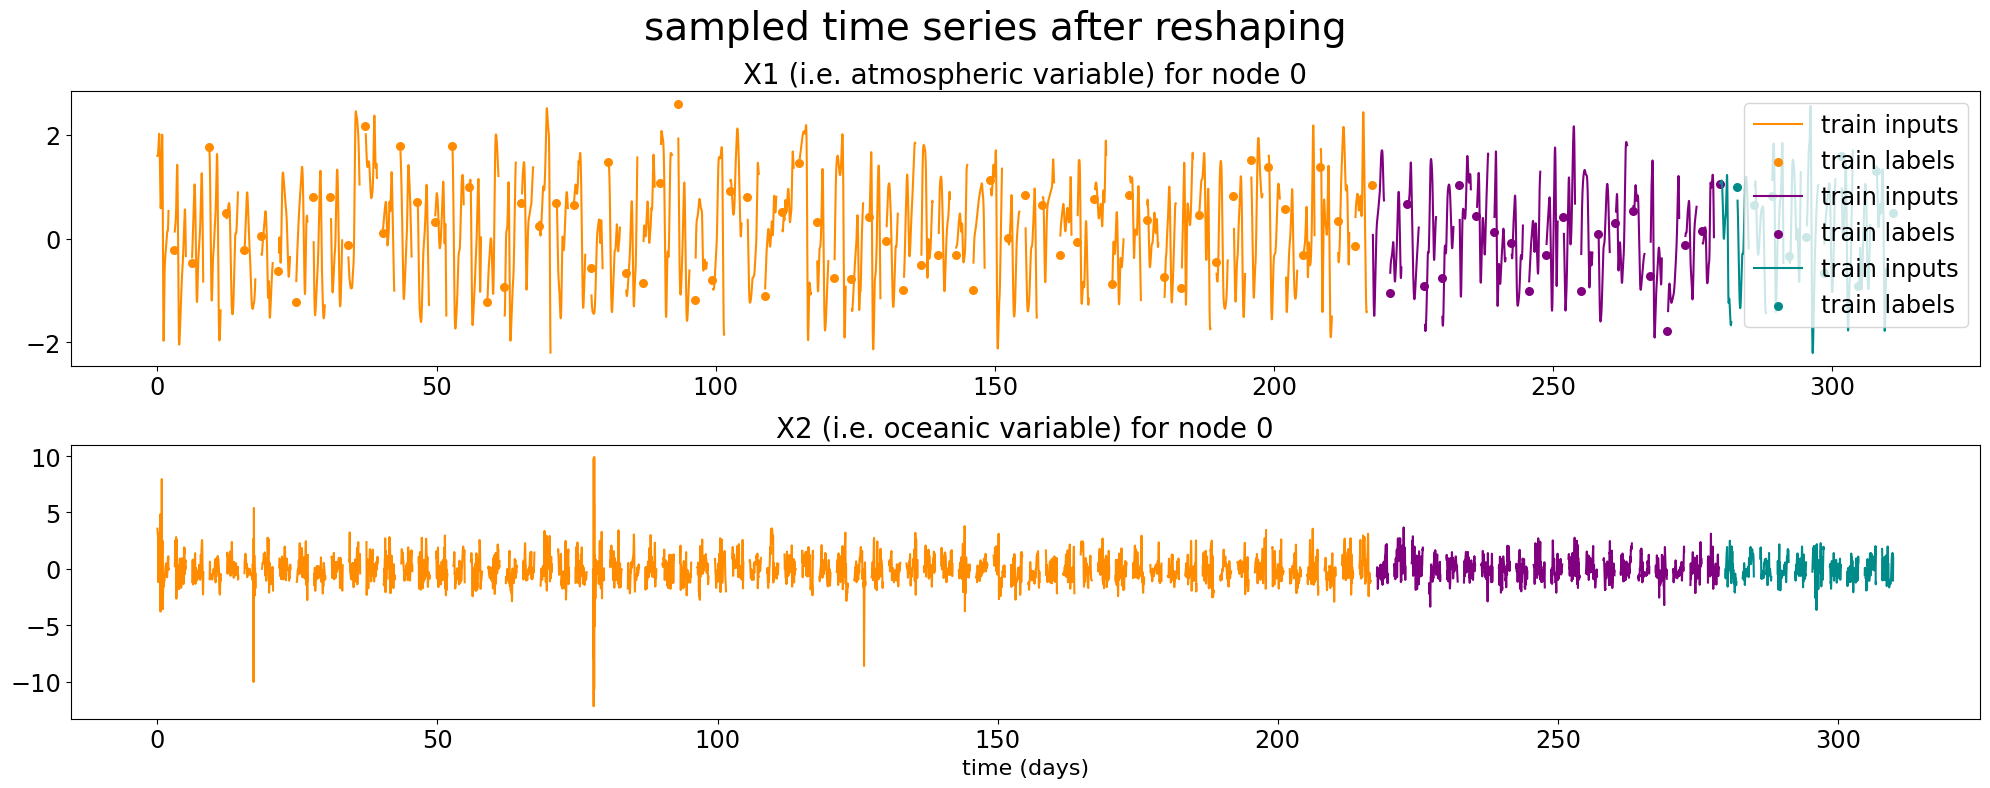

In [23]:
colors=["darkorange", "purple", "darkcyan"]
node = 0

# set up plot
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20, 8))

fig.suptitle("sampled time series after reshaping", size=28)
ax0.set_title("X1 (i.e. atmospheric variable) for node {}".format(node), size=20)
ax1.set_title("X2 (i.e. oceanic variable) for node {}".format(node), size=20)
plt.xlabel('time (days)', size=16)

# plot train, val, and test data
fig, (ax0, ax1) = train.plot(node, fig, ax0, ax1, data_type='train', color=colors[0])
fig, (ax0, ax1) = val.plot(node, fig, ax0, ax1, data_type='val', color=colors[1])
fig, (ax0, ax1) = test.plot(node, fig, ax0, ax1, data_type='test', color=colors[2])

# create legend
ax0.legend()
ax0.legend(handles = ax0.get_legend().legendHandles[0:6])
leg = ax0.get_legend()
[leg.legendHandles[i].set_color(colors[i//2]) for i in range(len(leg.legendHandles))]

plt.tight_layout()
plt.show()

### define GNN model

In [39]:
class GCN(Model):
    def __init__(self, n_hidden, output_dim, dropout=0.5):
        super().__init__()
        self.graph_conv = GCNConv(n_hidden)
        self.pool = GlobalSumPool()
        self.dropout = Dropout(dropout)
        self.dense = Dense(units=output_dim, activation=None) # linear regression layer

    def call(self, inputs):
        print(inputs)
        x = self.graph_conv(inputs)
        x = self.dropout(x)
        x = self.pool(x)
        out = self.dense(x)
        return out

    def predict(self, loader):
        predictions = []
        step = 0
        for batch in loader:
            step += 1
            print('step', step)
            inputs, target = batch
            p = model(inputs)
            predictions += p
        return predictions


### train the GNN

In [25]:
dataset[0].y.shape

(36, 1)

In [26]:
model = GCN(n_hidden=32, output_dim=dataset[0].y.shape[-1], dropout=0.5)
model.compile(optimizer='adam', loss='categorical_crossentropy')

2022-11-10 23:35:49.047511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch, epochs=10)

/Users/Guest/lorenzGNN/venv/lib/python3.10/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'lorenzDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/10
3/3 [==============================] - 1s 3ms/step - loss: -3.2286e-08
Epoch 2/10
3/3 [==============================] - 0s 4ms/step - loss: -3.2286e-08
Epoch 3/10
3/3 [==============================] - 0s 4ms/step - loss: -3.2286e-08
Epoch 4/10
3/3 [==============================] - 0s 5ms/step - loss: -3.2286e-08
Epoch 5/10
3/3 [==============================] - 0s 4ms/step - loss: -3.2286e-08
Epoch 6/10
3/3 [==============================] - 0s 4ms/step - loss: -3.2286e-08
Epoch 7/10
3/3 [==============================] - 0s 4ms/step - loss: -3.2286e-08
Epoch 8/10
3/3 [==============================] - 0s 6ms/step - loss: -3.2286e-08
Epoch 9/10
3/3 [==============================] - 0s 5ms/step - loss: -3.2286e-08
Epoch 10/10
3/3 [==============================] - 0s 4ms/step - loss: -3.2286e-08


In [40]:
# get predictions on the validation set
plot_with_predictions(model=model, graph_dataset=val, Loader=MixedLoader, batch_size=32, node=0, model_name='GCN')
# TODO: where is the shuffling coming from ???????
# TODO: figure out what's going wrong here & why it's taking so long (several factor times longer than training ???)

before loader initialization
after loader initialization
  29660/Unknown - 113s 4ms/step

In [ ]:
# plot predictions
